In [1]:
%%time
import numpy as np
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
pd.options.display.max_columns = None
dtrain=pd.read_csv("C:/Users/Landy/Desktop/Angela/esun_credit/train.csv")
# dtrain=dtrain.sort_values(by=['txkey'],ascending=True)
# dtest=pd.read_csv("C:/Users/Landy/Desktop/Angela/esun_credit/test.csv")
dtrain

Wall time: 4.03 s


,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,6881,113261,38038,513.80,5,0,N,0,N,N,0,5,N,0,33,172652.0,457,59333,N,0,102,0,516056
1,0,134508,45725,465.62,5,0,N,2,N,N,0,0,N,0,9,105114.0,451,0,N,5817,102,0,4376
2,6881,15408,188328,513.80,5,0,N,0,N,N,0,5,N,0,6,152458.0,457,59333,N,0,102,0,483434
3,6716,157159,29967,1016.11,5,62,N,5,N,N,0,5,N,0,5,172946.0,247,50436,N,3281,102,0,1407164
4,5975,105985,81305,713.66,5,62,N,4,N,N,0,5,N,0,6,182129.0,263,93775,N,5817,102,0,1051004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521782,6322,91008,15189,578.38,5,75,Y,8,NaN,NaN,0,6,N,0,4,191642.0,209,38222,N,5817,102,0,1478280
1521783,3226,145107,116252,435.32,5,75,Y,8,NaN,NaN,0,6,N,0,13,102338.0,192,90135,N,1458,102,0,661087
1521784,6769,162168,93598,1.38,5,75,Y,8,NaN,NaN,0,6,N,0,29,234618.0,373,79246,N,5817,102,0,167073
1521785,6032,45406,197460,1.38,5,75,Y,2,NaN,NaN,0,6,N,0,24,215218.0,373,79246,N,5817,102,0,338215


In [2]:
# fraud percent
print('No Frauds', round(dtrain['fraud_ind'].value_counts()[0]/len(dtrain) * 100,2), '% of the dataset')
print('Frauds', round(dtrain['fraud_ind'].value_counts()[1]/len(dtrain) * 100,2), '% of the dataset')

No Frauds 98.66 % of the dataset
Frauds 1.34 % of the dataset


In [3]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

columns_names=[c for c in dtrain.columns if c not in ['fraud_ind']]

uni=[]
for col in columns_names:
    uni.append(dtrain[col].unique())

from random import sample
ex_value=[]
uni_len=[]

# uni_len & ex_value
for i in range(len(uni)):
    uni_len.append(len(uni[i]))
    if len(uni[i])<10:
        ex_value.append(uni[i])
    else:
        ex_value.append(sample(list(uni[i]), 5))

columns_chinese=['收單行代碼(跟商店合作的銀行)','歸戶帳號(持卡人帳戶)','交易卡號(1 bacno對多cano)','交易金額-台幣(經轉換)','交易類別','消費地幣別','網路交易註記','交易型態(ex.刷磁條機)','Fallback註記(銀行懷疑的註記)','3DS交易註記(收簡訊)','支付型態(ex.linepay)','分期交易註記','分期期數(0~8)','授權日期(1到90天)','授權時間(時分秒)','MCC_CODE(商戶類別碼)','特約商店(買的地方)','超額註記碼(卡刷爆了)','消費城市','消費地國別','狀態碼(ex.停卡掛失逾期)','交易序號(流水號)']

dtrain_details = pd.DataFrame({
    'columns_names':columns_names, 
    'columns_chinese':columns_chinese,
    'uni_len':uni_len,
    'ex_value':ex_value
    })

dtrain_details

,columns_names,columns_chinese,uni_len,ex_value
0,acqic,收單行代碼(跟商店合作的銀行),6051,"[1472, 6419, 296, 3061, 3791]"
1,bacno,歸戶帳號(持卡人帳戶),95214,"[71445, 107127, 113242, 116748, 59599]"
2,cano,交易卡號(1 bacno對多cano),129413,"[594, 125835, 105961, 166893, 33502]"
3,conam,交易金額-台幣(經轉換),72961,"[1735.07, 387.45, 242.28, 616.68, 1378.3]"
4,contp,交易類別,7,"[5, 3, 6, 2, 4, 0, 1]"
5,csmcu,消費地幣別,72,"[66, 15, 26, 11, 3]"
6,ecfg,網路交易註記,2,"[N, Y]"
7,etymd,交易型態(ex.刷磁條機),11,"[5, 9, 2, 10, 8]"
8,flbmk,Fallback註記(銀行懷疑的註記),3,"[N, Y, nan]"
9,flg_3dsmk,3DS交易註記(收簡訊),3,"[N, Y, nan]"


In [4]:
def get_month(df):
    df['Month'] = 0
    df.loc[df['locdt'] <= 120, 'Month'] = 4
    df.loc[df['locdt'] <= 90, 'Month']  = 3
    df.loc[df['locdt'] <= 60, 'Month']  = 2
    df.loc[df['locdt'] <= 30, 'Month'] = 1
    return df

dtrain=get_month(dtrain)
# dtest=get_month(dtest)

In [5]:
# 00:00:00=時分秒，個位數分不補0 
dtrain['loctm'] = dtrain['loctm'].astype(int).astype(str)

def get_prefix(loctm):
    loctm = str(int(loctm))
    if len(loctm) < 6:
        loctm = (6 - len(loctm)) * '0' + loctm
    return loctm

dtrain['loctm_hour'] = dtrain['loctm'].apply(lambda x :get_prefix(x)[0:2])
# dtest['loctm_hour'] = dtrain['loctm'].apply(lambda x :get_prefix(x)[0:2])

In [6]:
fraud_1df = dtrain.loc[dtrain['fraud_ind'] == 1]
fraud_1df

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,Month,loctm_hour
70,3288,88538,81033,1.38,5,62,Y,8,N,N,1,5,N,0,7,45457,337,20984,N,621,93,2,651056,1,04
349,6881,157859,82925,513.80,5,0,N,0,N,N,1,5,N,0,23,154137,457,59360,N,0,102,0,503429,1,15
1133,6769,34663,73355,677.88,5,62,Y,8,N,N,1,5,N,0,54,172810,373,79663,N,5817,102,0,259268,2,17
1208,6856,74183,18151,229.61,5,62,Y,8,N,N,1,5,N,0,32,112902,288,69240,N,0,104,0,1423892,2,11
1254,6881,125183,48320,513.80,5,0,N,0,N,N,1,5,N,0,67,45823,457,59360,N,0,102,0,554270,3,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521552,6215,136379,138279,111.17,5,75,Y,2,NaN,NaN,1,6,N,0,16,172346,380,54238,N,6580,38,0,1849443,1,17
1521712,6215,136379,138279,111.17,5,75,Y,2,NaN,NaN,1,6,N,0,17,12250,380,54238,N,6580,38,0,1849997,1,01
1521718,6760,127255,129019,796.90,5,75,Y,2,NaN,NaN,1,6,N,0,5,182601,296,66694,N,3323,27,0,1837945,1,18
1521751,6215,96677,148700,1016.34,5,75,Y,2,NaN,NaN,1,6,N,0,28,203808,380,54238,N,6580,38,0,1862452,1,20


In [7]:
# flbmk,flg_3dsmk用NA填值
dtrain['flbmk']=dtrain['flbmk'].fillna('NA')
dtrain['flg_3dsmk']=dtrain['flg_3dsmk'].fillna('NA')

In [8]:
# 網路盜刷,1000~1500
dtrain['ecfgY_conam1000_1500']=0
dtrain.loc[(1000<dtrain.conam) & (dtrain.conam<1500), 'ecfgY_conam1000_1500'] = 1
dtrain.loc[dtrain.ecfg==str("N"), 'ecfgY_conam1000_1500'] = 0
# 實體盜刷,0~400
dtrain['ecfgN_conam0_400']=0
dtrain.loc[dtrain.conam<400, 'ecfgN_conam0_400'] = 1
dtrain.loc[dtrain.ecfg==str("Y"), 'ecfgN_conam0_400'] = 0

In [9]:
# 正常特約商店(mchno)
print(dtrain.mchno.value_counts(normalize=True)[:10])
# 盜刷特約商店(mchno)
print(fraud_1df.mchno.value_counts(normalize=True)[:10])
# mchno
dtrain.loc[dtrain['mchno'].isin([55807,45597,67588,66634,20984,11801,69240]),'mchno_danger']=1

0        0.032772
54828    0.025145
54238    0.024179
59333    0.021217
86584    0.013397
82174    0.012744
78638    0.012659
59369    0.011268
44859    0.010588
544      0.010235
Name: mchno, dtype: float64
54238    0.161582
54828    0.131712
55807    0.107541
45597    0.054188
67588    0.038860
66634    0.036256
20984    0.016212
11801    0.011840
69240    0.010219
79663    0.009383
Name: mchno, dtype: float64


In [10]:
# 正常消費國家(stocn)
print(dtrain.stocn.value_counts(normalize=True)[:10])
# 盜刷消費國家(stocn)
print(fraud_1df.stocn.value_counts(normalize=True)[:10])
# stocn
dtrain.loc[dtrain['stocn'].isin([104,38,46,75,102]),'stocn_danger']=1

102    0.863114
38     0.029118
46     0.027387
104    0.022011
75     0.013227
20     0.011751
52     0.010210
93     0.003431
42     0.002856
44     0.002754
Name: stocn, dtype: float64
104    0.330730
38     0.192631
46     0.149300
75     0.105822
102    0.061164
52     0.025547
6      0.020879
93     0.020192
27     0.016556
20     0.008008
Name: stocn, dtype: float64


In [11]:
#正常的contp
print(dtrain.contp.value_counts())
#盜刷的contp
print(fraud_1df.contp.value_counts())
# contp 
dtrain.loc[dtrain['contp'].isin([0,1,3,6]), 'contp'] = 6

5    1369806
4      69965
2      66147
6      13593
3       2148
1         84
0         44
Name: contp, dtype: int64
5    19553
4      777
3       14
2        8
6        3
Name: contp, dtype: int64


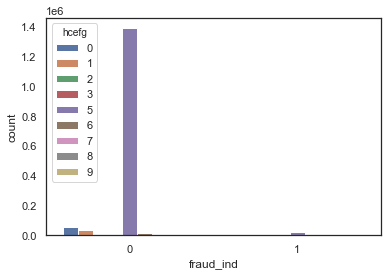

In [12]:
# 支付型態，大多用5
sns.countplot(x='fraud_ind',hue='hcefg',data=dtrain)
# hcefg 
dtrain.loc[dtrain['hcefg'].isin([1,2,3,4]), 'hcefg'] = 4

([<matplotlib.patches.Wedge at 0x41167f48>,
 [Text(1.013545136828794, 0.427464917403407, '251'),
  Text(0.5091885742734823, 0.9750523041505715, '247'),
  Text(-0.03696132994233155, 1.0993788519381724, '263'),
  Text(-0.4986112957621424, 0.9805033277548819, '457'),
  Text(-0.8165722802947168, 0.7370276189223078, '292'),
  Text(-0.9926496519705789, 0.47396905852881266, '264'),
  Text(-1.0811076905088841, 0.2029930085558302, '343'),
  Text(-1.0994975163701817, -0.03324472132237754, '451'),
  Text(-1.075508653491801, -0.2308270700421703, '380'),
  Text(-1.020196481300287, -0.41133823010086645, '289')],
 [Text(0.5528428019066148, 0.23316268222004013, '13%'),
  Text(0.2777392223309903, 0.5318467113548572, '9%'),
  Text(-0.020160725423089932, 0.5996611919662759, '7%'),
  Text(-0.27196979768844126, 0.5348199969572083, '7%'),
  Text(-0.4454030619789364, 0.4020150648667133, '5%'),
  Text(-0.5414452647112248, 0.25852857737935236, '4%'),
  Text(-0.5896951039139366, 0.110723459212271, '4%'),
  Text

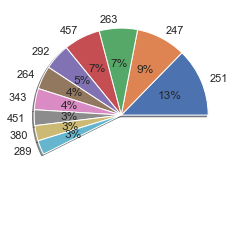

In [13]:
# c=dtrain.mcc.value_counts(normalize = True)
c=dtrain.mcc.value_counts(normalize = True)[:10]
# mcc 不屬於251,247,263,457,292,264,343則歸類於343
dtrain.loc[~dtrain['mcc'].isin([251,247,263,457,292,264,343]), 'mcc'] = 343
# 正常前10大商戶類別(mcc)
plt.pie(c.values,labels=c.index,
autopct='%.0f%%',radius=1,explode=None,shadow=True)

C:\Users\Landy\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Landy\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


([<matplotlib.patches.Wedge at 0x4122a888>,
 [Text(0.9172080123232079, 0.6072309792246358, '289'),
  Text(-0.136064137384865, 1.091552358120174, '380'),
  Text(-0.9570531983943015, 0.5422630131617296, '288'),
  Text(-1.0523521123514952, -0.3202421453046841, '192'),
  Text(-0.785194972615412, -0.7703692977913141, '203'),
  Text(-0.6704285642564956, -0.8720811546117564, '337'),
  Text(-0.5544049058153694, -0.9500711554446076, '286'),
  Text(-0.4344229197300907, -1.0105823701278305, '296'),
  Text(-0.3136578365348432, -1.054333325651941, '408'),
  Text(-0.191291604424889, -1.0832393650881378, '277')],
 [Text(0.5002952794490224, 0.33121689775889224, '19%'),
  Text(-0.07421680220992637, 0.5953921953382767, '17%'),
  Text(-0.5220290173059825, 0.2957798253609434, '13%'),
  Text(-0.5740102431008155, -0.17467753380255494, '13%'),
  Text(-0.4282881668811338, -0.4202014351588986, '2%'),
  Text(-0.36568830777627026, -0.4756806297882307, '2%'),
  Text(-0.3024026758992923, -0.5182206302425132, '2%')

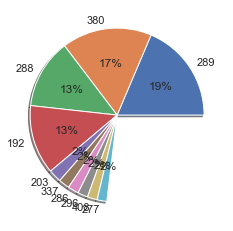

In [14]:
# d=fraud_1df.mcc.value_counts(normalize = True)
d=fraud_1df.mcc.value_counts(normalize = True)[:10]

# mcc 
fraud_1df.loc[fraud_1df['mcc'].isin([289,380,288,192]), 'mcc_danger'] = 1
# 盜刷前10大消費商戶類別(mcc)
plt.pie(d.values,labels=d.index,
autopct='%.0f%%',radius=1,explode=None,shadow=True)

In [15]:
# 卡沒被刷爆的盜刷：小額盜刷 or 800~1000左右
dtrain['ovrltN_conam0_200_or_800_1200']=0
dtrain.loc[(dtrain.conam<200) & (800<dtrain.conam) & (dtrain.conam<1200), 'ovrltN_conam0_200_or_800_1200'] = 1
dtrain.loc[dtrain.ovrlt==str("Y"), 'ovrltN_conam0_200_or_800_1200'] = 0
# 卡刷爆了：1200~3000左右
dtrain['ovrltY_conam1200_3000']=0
dtrain.loc[(1200<dtrain.conam) & (dtrain.conam<3000), 'ovrltY_conam1200_3000'] = 1
dtrain.loc[dtrain.ovrlt==str("N"), 'ovrltY_conam1200_3000'] = 0

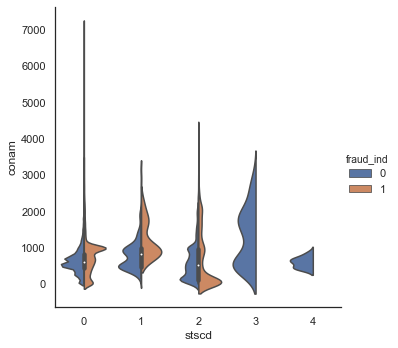

In [16]:
# 狀態碼，3 & 4都沒被盜刷
sns.catplot(x='stscd',y='conam',hue='fraud_ind',kind="violin", split=True,data=dtrain)
# 將狀態碼(stscd) 3.4合併
dtrain.loc[dtrain['stscd'].isin([3,4]),'stscd']=3

In [17]:
print(dtrain.etymd.value_counts(normalize=True)[:10])
print(fraud_1df.etymd.value_counts(normalize=True)[:10])
# etymd
dtrain.loc[dtrain['etymd']==8,'etymd_danger']=1

5    0.265879
2    0.248175
4    0.210609
8    0.160335
0    0.085440
9    0.019764
1    0.006794
3    0.001544
6    0.001300
7    0.000150
Name: etymd, dtype: float64
8    0.568312
2    0.383395
5    0.009973
0    0.008990
4    0.008597
9    0.008352
6    0.007124
7    0.003292
1    0.001130
3    0.000835
Name: etymd, dtype: float64


In [18]:
print(dtrain.acqic.value_counts(normalize=True)[:10])
print(fraud_1df.acqic.value_counts(normalize=True)[:10])
# acqic
dtrain.loc[dtrain.acqic.isin([3348,3321,6215,6540,5720,6760,3207]),'acqic_danger']=1

6769    0.164865
6716    0.132349
5975    0.082108
6881    0.065284
6189    0.060083
6767    0.053376
6032    0.040900
6231    0.036104
0       0.031502
3348    0.029526
Name: acqic, dtype: float64
3348    0.198035
3221    0.120609
6215    0.102186
6540    0.081995
5720    0.058659
6760    0.046328
3207    0.033702
6331    0.016556
6769    0.012822
3288    0.012085
Name: acqic, dtype: float64


In [19]:
# fillna
dtrain.fillna(value=0,inplace=True)
# handle Y,N,NA
dtrain.replace('Y',1,inplace=True)
dtrain.replace('N',0,inplace=True)
dtrain.replace('NA',2,inplace=True)

In [26]:
from sklearn.model_selection import train_test_split

col_demo=[c for c in dtrain.columns if c  in ['conam','contp','ecfg','etymd', 'flbmk', 'hcefg','ovrlt','stscd','month','loctm_hour']]

dtrain[dtrain.columns]=dtrain[dtrain.columns].astype(int)
#fraud_ind=y
X_traind, X_validd, y_traind, y_validd = train_test_split(dtrain[col_demo].values, dtrain['fraud_ind'].values, test_size=0.01, random_state=666)
X_traind

array([[465,   5,   0, ...,   0,   0,  10],
       [513,   5,   0, ...,   0,   0,  22],
       [803,   5,   0, ...,   0,   0,  17],
       ...,
       [735,   5,   0, ...,   0,   0,  14],
       [708,   5,   0, ...,   0,   0,  17],
       [925,   5,   0, ...,   0,   0,  15]])

In [27]:
import joblib
from xgboost.sklearn import XGBClassifier
model =XGBClassifier(n_estimators=100, verbose=1,random_state=5566)

model.fit(X_traind,y_traind)
joblib.dump(model,'C:/Users/Landy/Desktop/Angela/esun_credit/demo_model.dat')

['C:/Users/Landy/Desktop/Angela/esun_credit/demo_model.dat']

In [28]:
request_list=[793,5,0,4,0,5,0,0,19]
request_list = np.array(request_list).reshape((1,-1))
model.predict_proba(request_list)

array([[9.9942315e-01, 5.7686295e-04]], dtype=float32)